In [ ]:
!pip install lazypredict
!pip install lightgbm

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import math
from lazypredict.Supervised import LazyClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix
# Filter out specific warning by category
warnings.filterwarnings("ignore")
# Your code here that triggers the warning
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Understanding

## Data loading

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/portofolio/Classification of sloth/dataset.csv")
train_df.drop(["Unnamed: 0"], axis=1, inplace=True)
train_df.head()

,claw_length_cm,endangered,size_cm,specie,sub_specie,tail_length_cm,weight_kg
0,6.83,critically_endangered,52.00,three_toed,Pygmy three-toed sloth,4.45,3.57
1,8.26,critically_endangered,50.08,three_toed,Pygmy three-toed sloth,6.29,2.84
2,8.66,critically_endangered,51.50,three_toed,Pygmy three-toed sloth,4.55,1.26
3,8.47,critically_endangered,50.12,three_toed,Pygmy three-toed sloth,6.98,2.39
4,7.10,critically_endangered,51.36,three_toed,Pygmy three-toed sloth,5.41,3.16


## Exploratory Data Analysis

### Apa saja jenis variabel pada dataset?

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   claw_length_cm  5000 non-null   float64
 1   endangered      5000 non-null   object 
 2   size_cm         5000 non-null   float64
 3   specie          5000 non-null   object 
 4   sub_specie      5000 non-null   object 
 5   tail_length_cm  5000 non-null   float64
 6   weight_kg       5000 non-null   float64
dtypes: float64(4), object(3)
memory usage: 273.6+ KB


### Apakah ada data type yang tidak sesuai dengan value?

hasil dari df.info() menunjukan TYPE, STATE, ADMINISTRATIVE_AREA_LEVEL_2, LOCALITY, SUBLOCALITY merupakan data nominal dan BATH merupakan data diskrit.      

In [ ]:
train_df['endangered'].unique()

array(['critically_endangered', 'vulnerable', 'least_concern'],
      dtype=object)

In [ ]:
train_df['specie'].unique()

array(['three_toed', 'two_toed'], dtype=object)

In [ ]:
train_df['sub_specie'].unique()

array(['Pygmy three-toed sloth', 'Maned three-toed sloth',
       'Pale-throated sloth', 'Brown-throated sloth',
       'Linnaeus’s two-toed sloth', 'Hoffman’s two-toed sloth'],
      dtype=object)

In [ ]:
numeric_cols = train_df.select_dtypes(include=['int', 'float']).columns.tolist()
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()
print(numeric_cols)
print(categorical_cols)

['claw_length_cm', 'size_cm', 'tail_length_cm', 'weight_kg']
['endangered', 'specie', 'sub_specie']


In [ ]:
train_df[categorical_cols] = train_df[categorical_cols].astype('category')

In [ ]:
categorical_cols = train_df.select_dtypes(include=['category']).columns.tolist()

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   claw_length_cm  5000 non-null   float64 
 1   endangered      5000 non-null   category
 2   size_cm         5000 non-null   float64 
 3   specie          5000 non-null   category
 4   sub_specie      5000 non-null   category
 5   tail_length_cm  5000 non-null   float64 
 6   weight_kg       5000 non-null   float64 
dtypes: category(3), float64(4)
memory usage: 171.5 KB


### Apakah ada missing value?

In [ ]:
train_df.isna().sum()

claw_length_cm    0
endangered        0
size_cm           0
specie            0
sub_specie        0
tail_length_cm    0
weight_kg         0
dtype: int64

### Apakah ada outlier value?

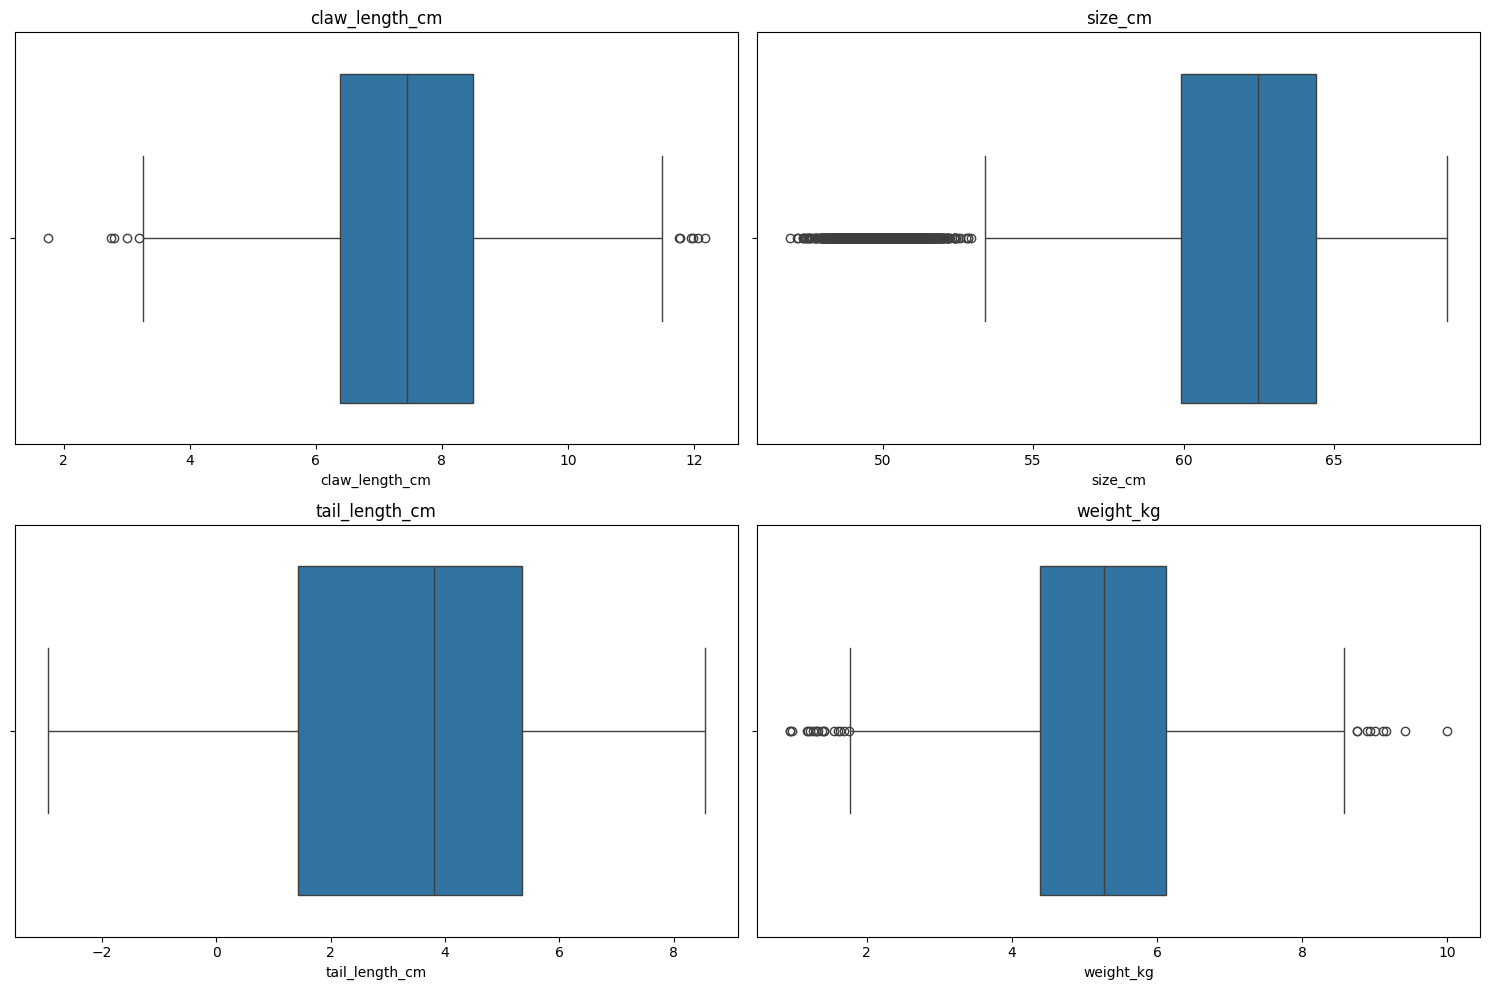

In [ ]:
count_numeric_cols = len(numeric_cols)
num_rows = (count_numeric_cols + 1) // 2  # Calculate the number of rows needed for the grid layout

fig, axes = plt.subplots(num_rows, 2, figsize=(15, 5*num_rows))  # Create a grid layout
axes = axes.flatten()  # Flatten the 2D array of axes to simplify indexing

for index, col in enumerate(numeric_cols):
    sns.boxplot(x=train_df[col], ax=axes[index])
    axes[index].set_title(col)

# Hide any remaining empty subplots
for ax in axes[count_numeric_cols:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

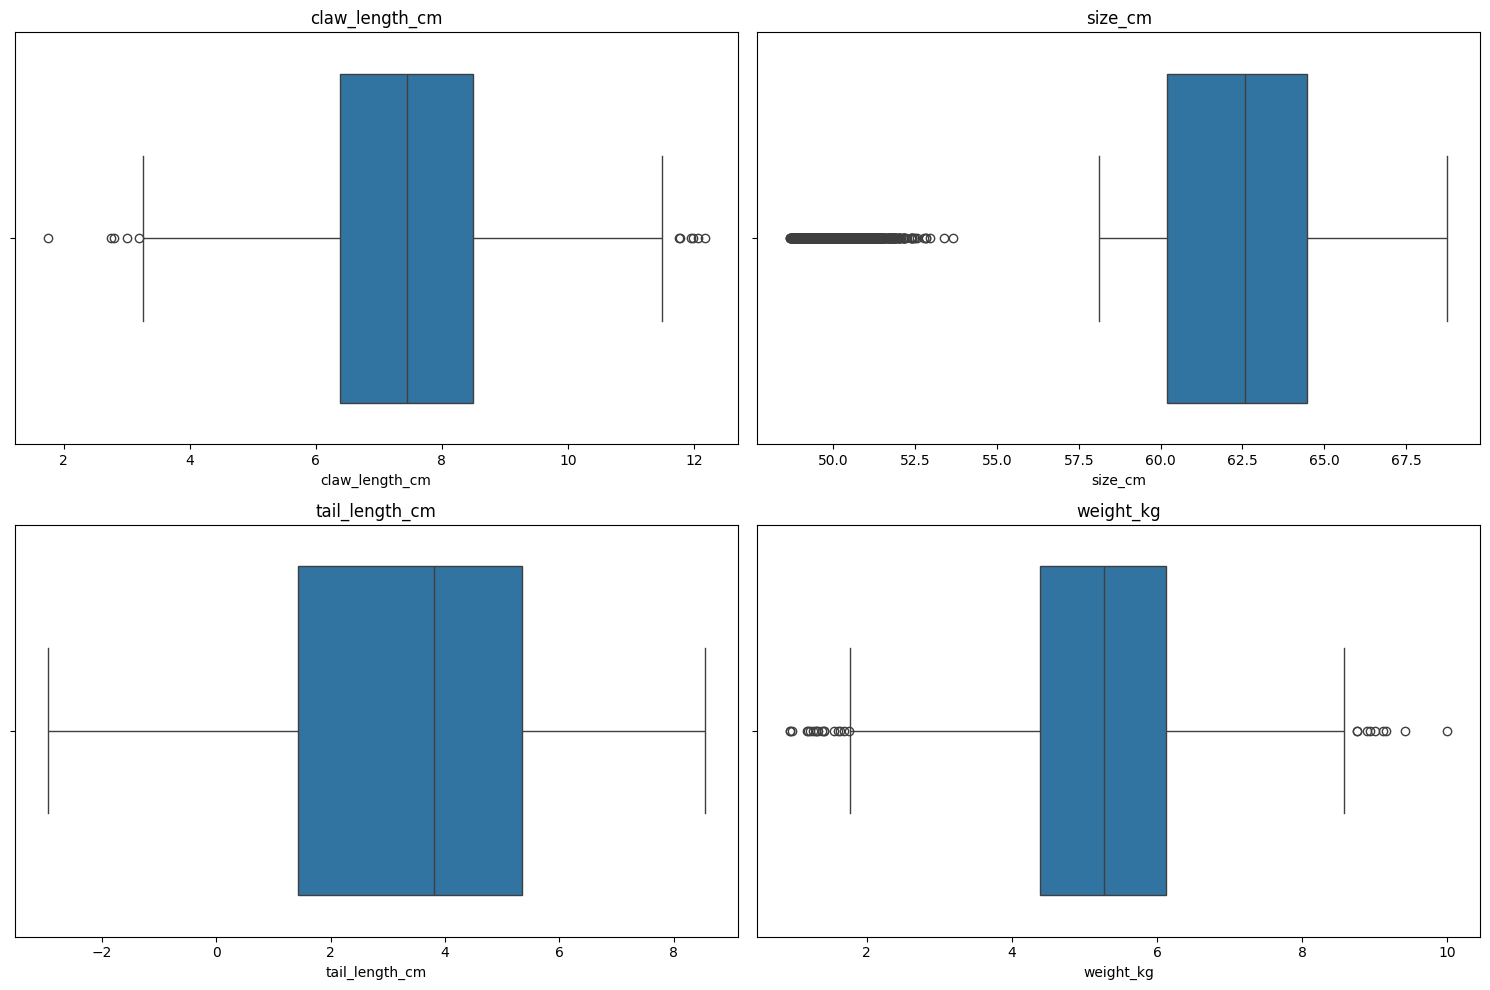

In [ ]:
fig, axes = plt.subplots(num_rows, 2, figsize=(15, 5*num_rows))  # Create a grid layout
axes = axes.flatten()  # Flatten the 2D array of axes to simplify indexing
for index, col in enumerate(numeric_cols):
  Q1 = train_df[col].quantile(0.25)
  Q3 = train_df[col].quantile(0.75)
  IQR=Q3-Q1
  train_df[col]=train_df[col][~((train_df[col]<(Q1-2.5*IQR))|(train_df[col]>(Q3+2.5*IQR)))]
  # Impute missing values with the median
  sns.boxplot(x=train_df[col], ax=axes[index])
  axes[index].set_title(col)
train_df.dropna(axis=1, inplace=True)
# Hide any remaining empty subplots
for ax in axes[count_numeric_cols:]:
    ax.axis('off')
plt.tight_layout()
plt.show()

### Bagaimana distribusi variabel dalam dataset?

In [ ]:
train_df.describe(include="all")

,claw_length_cm,endangered,specie,sub_specie,tail_length_cm,weight_kg
count,5000.00,5000,5000,5000,5000.00,5000.00
unique,NaN,3,2,6,NaN,NaN
top,NaN,least_concern,three_toed,Hoffman’s two-toed sloth,NaN,NaN
freq,NaN,4390,2662,1198,NaN,NaN
mean,7.42,NaN,NaN,NaN,3.41,5.25
std,1.52,NaN,NaN,NaN,2.33,1.27
min,1.75,NaN,NaN,NaN,-2.94,0.95
25%,6.38,NaN,NaN,NaN,1.44,4.38
50%,7.45,NaN,NaN,NaN,3.81,5.27
75%,8.49,NaN,NaN,NaN,5.35,6.13


**Univariate Analysis**

**Categorical Features**

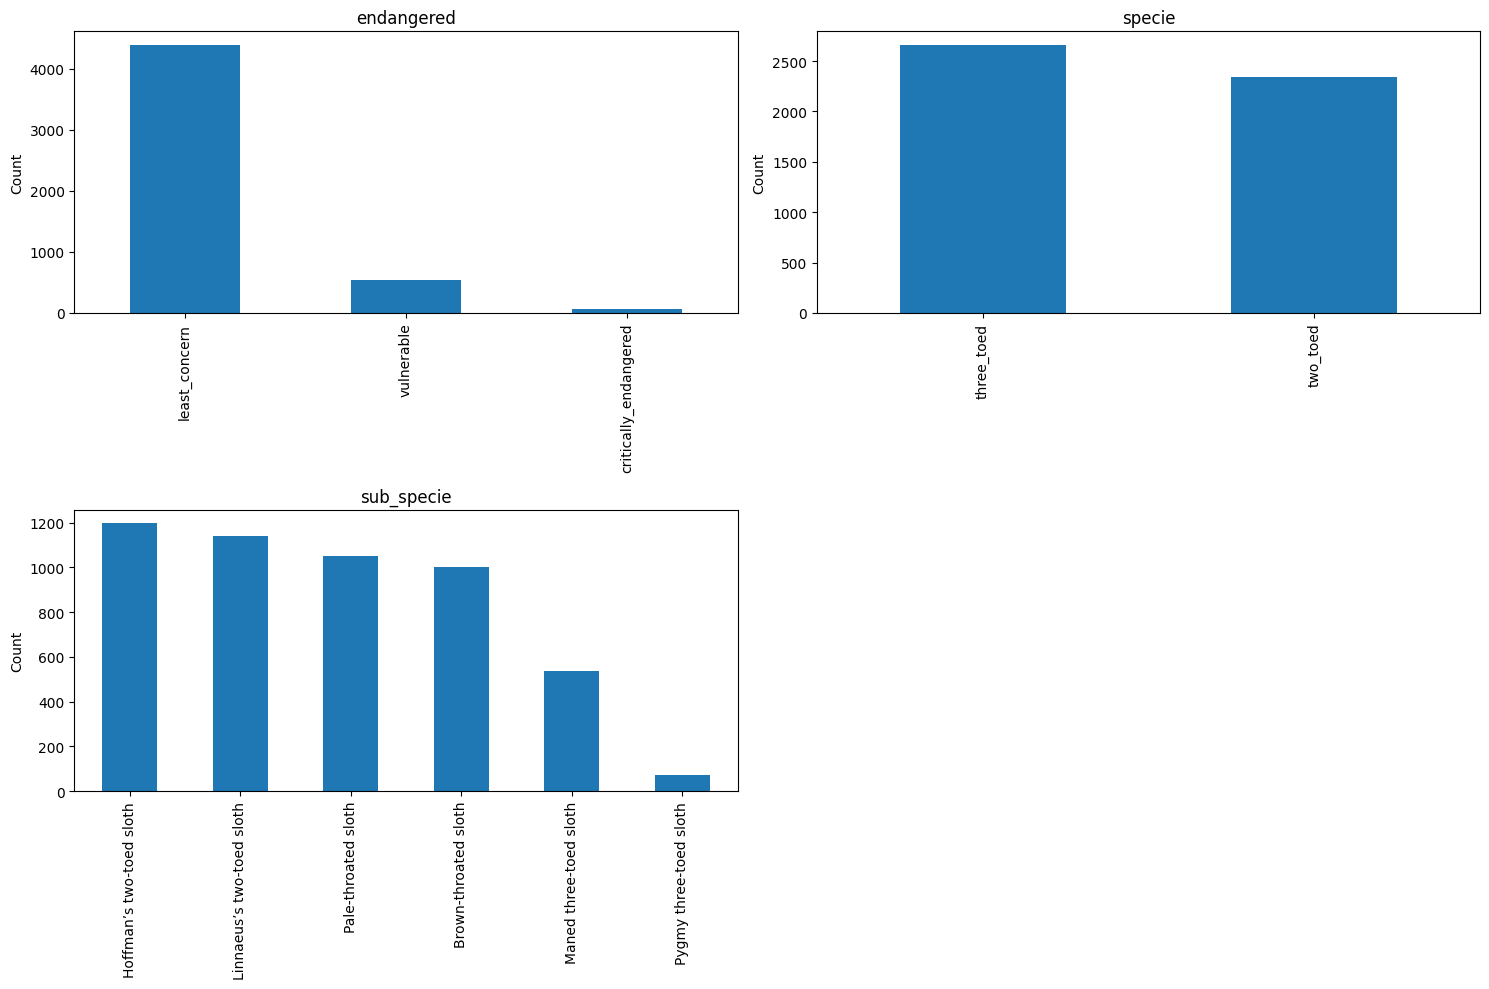

In [ ]:
count_categorical_cols = len(categorical_cols)
num_rows = (count_categorical_cols + 1) // 2  # Calculate the number of rows needed for the grid layout

fig, axes = plt.subplots(num_rows, 2, figsize=(15, 5*num_rows))  # Create a grid layout
axes = axes.flatten()  # Flatten the 2D array of axes to simplify indexing

for index, col in enumerate(categorical_cols):
    count = train_df[col].value_counts()
    percent = 100 * train_df[col].value_counts(normalize=True).round(2)
    df = pd.DataFrame({'jumlah sampel': count, 'persentase': percent})
    ax = axes[index]
    count.plot(kind='bar', ax=ax, title=col)
    ax.set_ylabel('Count')

# Hide any remaining empty subplots
for ax in axes[count_categorical_cols:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


**Numerical Features**

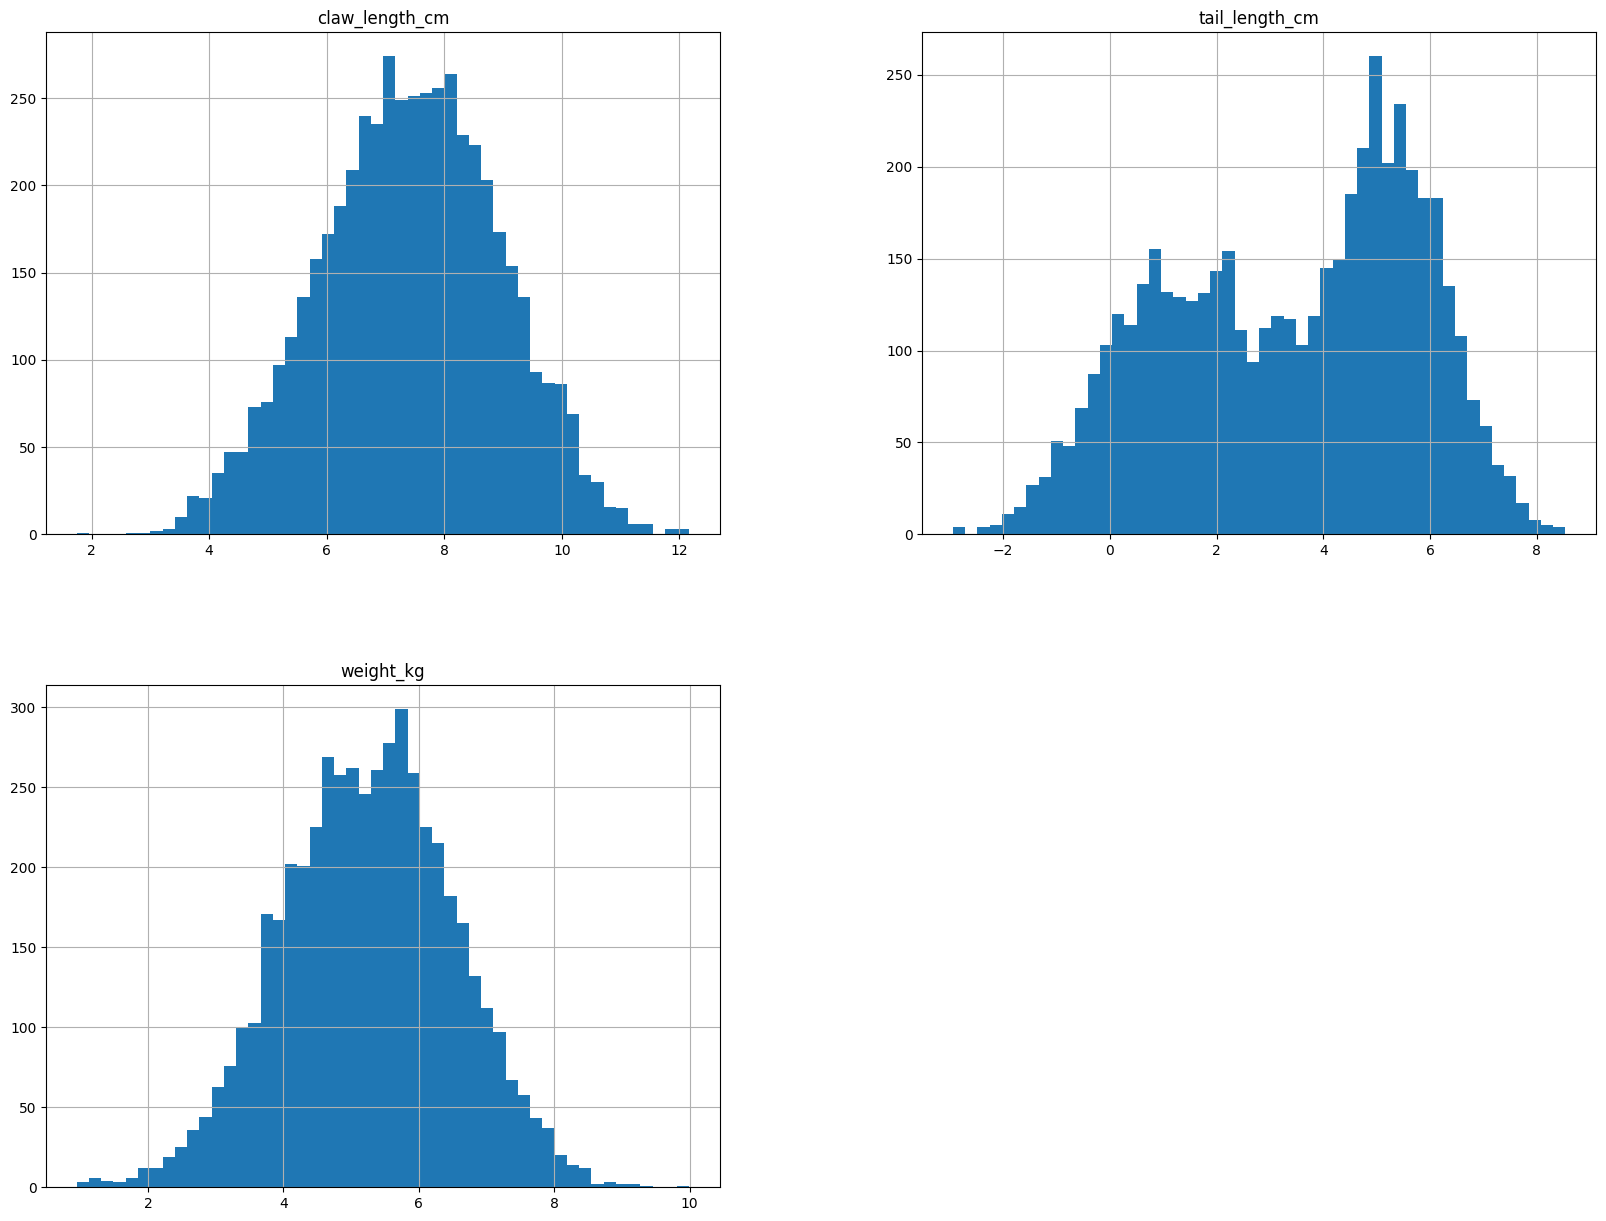

In [ ]:
train_df.hist(bins=50, figsize=(20,15))
plt.show()

**Multivariate Analysis**

**Categorical Feature**

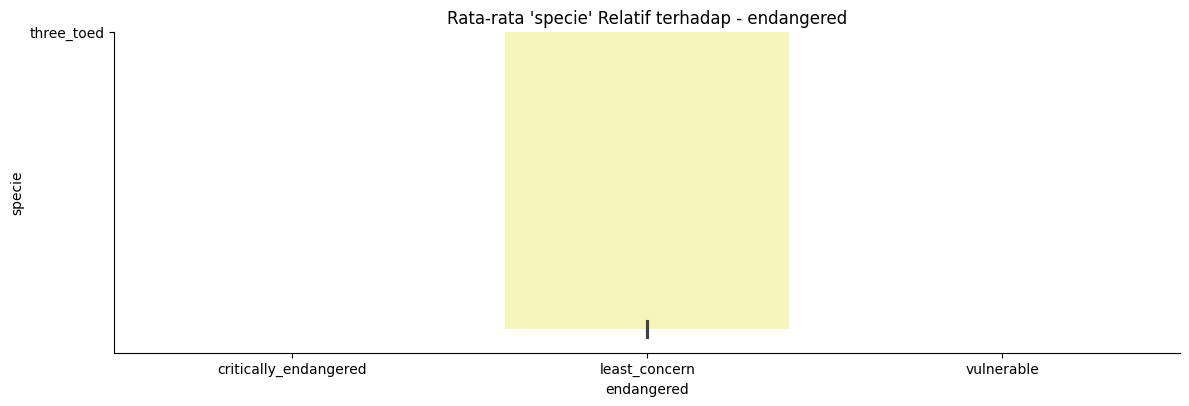

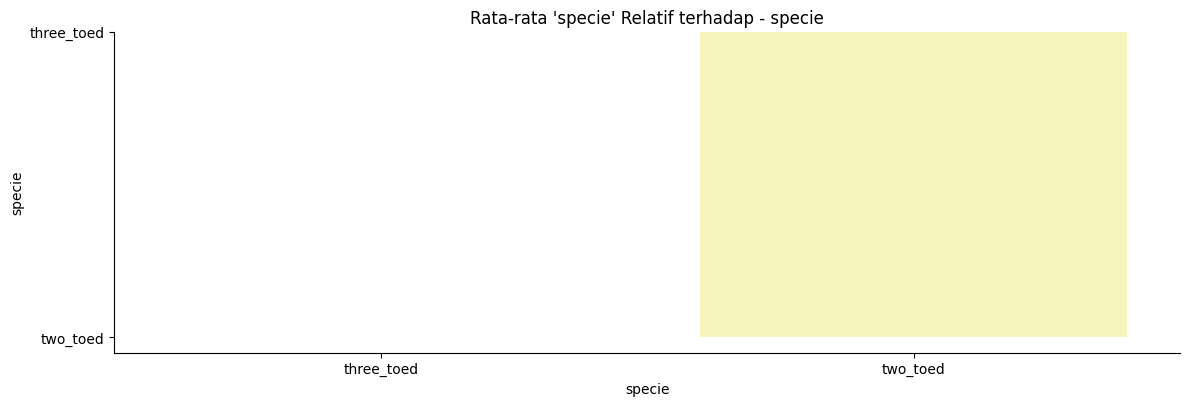

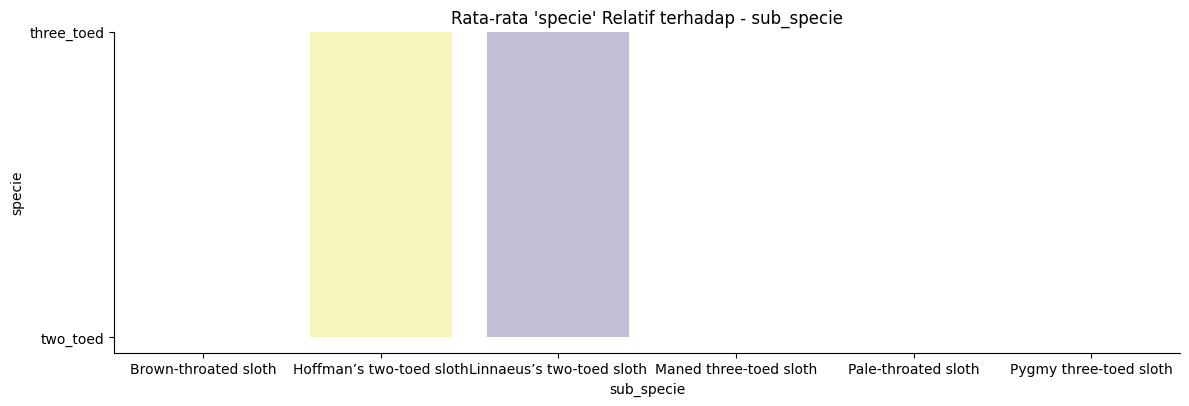

In [ ]:
for col in categorical_cols:
  if col == "specia":
    continue
  sns.catplot(x=col, y="specie", kind="bar", dodge=False, height = 4, aspect = 3,  data=train_df, palette="Set3")
  plt.title("Rata-rata 'specie' Relatif terhadap - {}".format(col))
plt.show()

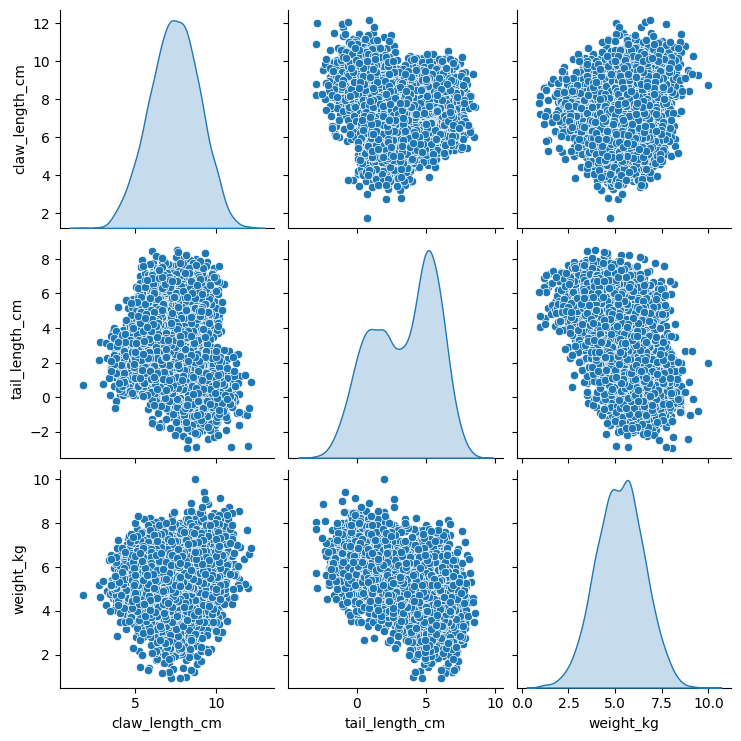

In [ ]:
# Mengamati hubungan antar fitur numerik dengan fungsi pairplot()
sns.pairplot(train_df, diag_kind = 'kde')

Text(0.5, 1.0, 'Correlation Matrix untuk Fitur Numerik ')

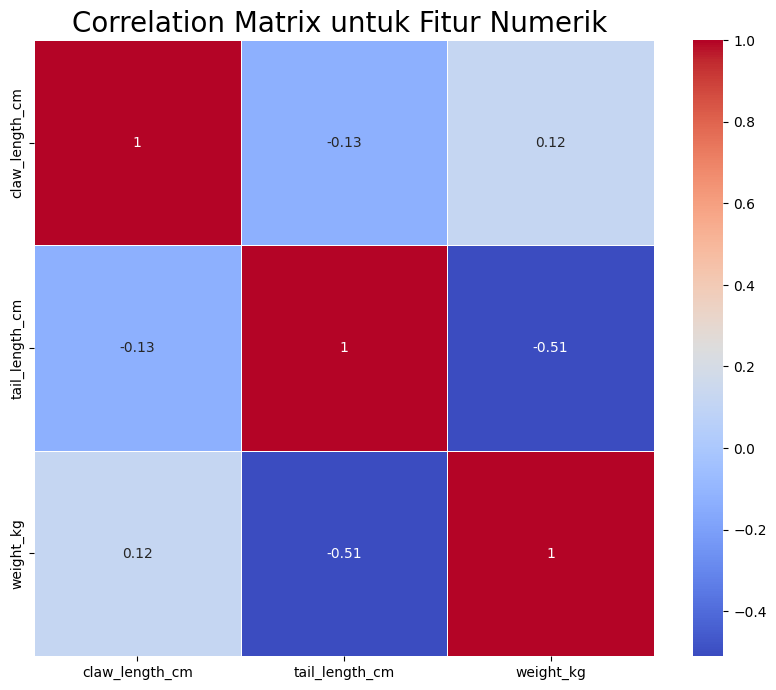

In [ ]:
plt.figure(figsize=(10, 8))
correlation_matrix = train_df.corr(method='spearman').round(2)

# Untuk menge-print nilai di dalam kotak, gunakan parameter anot=True
sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, )
plt.title("Correlation Matrix untuk Fitur Numerik ", size=20)

## Data Preparation

### Encoding Fitur Kategori


In [ ]:
train_df.drop(["endangered", "sub_specie"], axis=1, inplace=True)

In [ ]:
categorical_cols = train_df.select_dtypes(include=['category']).columns.tolist()
categorical_column = []
for i in categorical_cols:
  if i == "specie":
    continue
  train_df = pd.concat([train_df, pd.get_dummies(train_df[i], prefix=i)],axis=1)
  categorical_column.append(i)
train_df.drop(categorical_column, axis=1, inplace=True)
train_df.head()

,claw_length_cm,specie,tail_length_cm,weight_kg
0,6.83,three_toed,4.45,3.57
1,8.26,three_toed,6.29,2.84
2,8.66,three_toed,4.55,1.26
3,8.47,three_toed,6.98,2.39
4,7.10,three_toed,5.41,3.16


In [ ]:
enc = LabelEncoder()
train_df["specie"] = enc.fit_transform(train_df[["specie"]])

In [ ]:
enc.classes_

array(['three_toed', 'two_toed'], dtype=object)

### PCA

In [ ]:
train_df.head()

,claw_length_cm,specie,tail_length_cm,weight_kg
0,6.83,0,4.45,3.57
1,8.26,0,6.29,2.84
2,8.66,0,4.55,1.26
3,8.47,0,6.98,2.39
4,7.10,0,5.41,3.16


In [ ]:
pca = PCA(n_components=3, random_state=123)
pca.fit(train_df[["claw_length_cm", "tail_length_cm", "weight_kg"]])
princ_comp = pca.transform(train_df[["claw_length_cm", "tail_length_cm", "weight_kg"]])

In [ ]:
pca.explained_variance_ratio_.round(3)

array([0.646, 0.237, 0.116])

In [ ]:
pca = PCA(n_components=1, random_state=123)
pca.fit(train_df[["claw_length_cm", "tail_length_cm", "weight_kg"]])
train_df['body'] = pca.transform(train_df.loc[:, ("claw_length_cm", "tail_length_cm", "weight_kg")]).flatten()
train_df.drop(["claw_length_cm", "tail_length_cm", "weight_kg"], axis=1, inplace=True)

### Standarisasi

In [ ]:
X = train_df.drop(["specie"],axis=1)
y = train_df["specie"]

In [ ]:
scaler = StandardScaler()
numeric_cols = ["body"]
scaler.fit(X[numeric_cols])
X[numeric_cols] = scaler.transform(X.loc[:, numeric_cols])
X[numeric_cols].head()

,body
0,-0.65
1,-1.35
2,-0.88
3,-1.66
4,-1.05


### Train-Test-Split

In [ ]:
X.head()

,body
0,-0.65
1,-1.35
2,-0.88
3,-1.66
4,-1.05


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 30, random_state = 123)

## Model Development

### Model Development dengan lazy regressor

In [ ]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
# Get the best model based on Accuracy
best_model = models.loc[models['Accuracy'].idxmax()]
print("Best model based on Accuracy:")
print(best_model)

 97%|█████████▋| 28/29 [00:11<00:00,  1.64it/s]

[LightGBM] [Info] Number of positive: 2327, number of negative: 2643
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 4970, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.468209 -> initscore=-0.127335
[LightGBM] [Info] Start training from score -0.127335


100%|██████████| 29/29 [00:11<00:00,  2.44it/s]

Best model based on Accuracy:
Accuracy            0.93
Balanced Accuracy   0.93
ROC AUC             0.93
F1 Score            0.93
Time Taken          0.06
Name: LinearSVC, dtype: float64


In [ ]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LinearSVC,0.93,0.93,0.93,0.93,0.06
LogisticRegression,0.93,0.93,0.93,0.93,0.05
CalibratedClassifierCV,0.93,0.93,0.93,0.93,0.15
SGDClassifier,0.93,0.93,0.93,0.93,0.13
XGBClassifier,0.90,0.88,0.88,0.90,1.51
SVC,0.90,0.88,0.88,0.90,1.26
QuadraticDiscriminantAnalysis,0.90,0.88,0.88,0.90,0.02
Perceptron,0.90,0.88,0.88,0.90,0.04
PassiveAggressiveClassifier,0.90,0.88,0.88,0.90,0.05


In [ ]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'max_iter': [1000, 2000, 3000],
}

grid_search = GridSearchCV(LinearSVC(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Best hyperparameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Best hyperparameters: {'C': 100, 'max_iter': 1000}


## Evaluation Model

In [ ]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

In [ ]:
evaluation = {
    "accuracy":[accuracy],
    "precision":[precision],
    "recall":[recall],
    "f1 score":[f1]
}
evaluation_df = pd.DataFrame(evaluation)
evaluation_df

,accuracy,precision,recall,f1 score
0,0.90,0.90,0.82,0.86


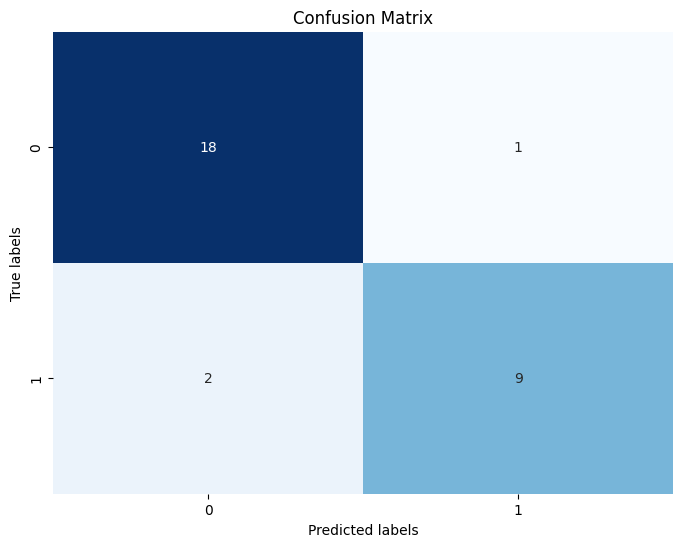

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()